[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)


# Filtering and trimming messages

## Review

これで、いくつかのことを深く理解することができました：

- グラフの状態スキーマをカスタマイズする方法
- カスタム state reducer の定義方法
- 複数のグラフ state schema の使用方法

## Goals

さて、これらのコンセプトを LangGraph のモデルで使い始めましょう！

次の数セッションでは、長期記憶(long-term memory)を持つチャットボットを作ります。

私たちのチャットボットはメッセージを使うので、まずはグラフステートでメッセージを扱う高度な方法についてもう少しお話ししましょう。


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

[tracing](https://docs.smith.langchain.com/concepts/tracing)には[LangSmith](https://docs.smith.langchain.com/)を使います。

`langchain-academy`というプロジェクトにログを記録します。


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

まず、メッセージを定義します。


In [3]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(
        "海の哺乳類を研究していると言いましたね？",
        name="Bot",
    )
]
messages.append(
    HumanMessage(
        "はい、クジラについては知っています。でも、他にどんなことを学べばいいですか？",
        name="Lance",
    )
)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

海の哺乳類を研究していると言いましたね？
================================ Human Message =================================
Name: Lance

はい、クジラについては知っています。でも、他にどんなことを学べばいいですか？


メッセージをチャットモデルに渡すことができます。


In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(messages)

AIMessage(content='クジラについて深く理解するためには、以下のトピックを学ぶと良いでしょう：\n\n1. **生態と行動**: クジラの生活習慣、繁殖行動、移動パターン、食性などを理解することが重要です。\n\n2. **種の多様性**: クジラには多くの異なる種が存在します。例えば、ザトウクジラ、シロナガスクジラ、マッコウクジラなど、各種の特性や生態を学ぶことが役立ちます。\n\n3. **音とコミュニケーション**: クジラは音を使ってコミュニケーションをとります。彼らの歌や音のパターンを理解することで、社会構造や行動を知る手助けになります。\n\n4. **環境問題**: 海洋環境の変化や人間活動がクジラに与える影響（例：気候変動、海洋汚染、漁業の影響）について学ぶことが重要です。\n\n5. **保護活動**: クジラを保護するための取り組みや法規制、国際的な協力について知識を深めることが必要です。\n\n6. **研究方法**: クジラの研究に使われるテクニックやツール（例えば、タグ付け、音響モニタリングなど）を学ぶことで、実際の研究に役立ちます。\n\nこれらのトピックを掘り下げることで、クジラについての理解が深まるでしょう。興味のある分野から始めてみてください！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 385, 'prompt_tokens': 53, 'total_tokens': 438, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_482c22a7bc', 'finish_reason': 'stop', 'logprobs': None}, id='run-95c3be18-0f6f-4d7d-a0a9-1

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')


`MessagesState`を使えば、単純なグラフの中でチャットモデルを動かすことができます。


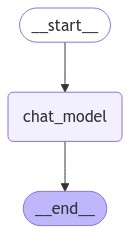

In [5]:
from IPython.display import Image, display
from langchain_core.messages.base import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END


# Node
def chat_model_node(state: MessagesState) -> dict[str, BaseMessage]:
    return {"messages": llm.invoke(state["messages"])}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

海の哺乳類を研究していると言いましたね？
================================ Human Message =================================
Name: Lance

はい、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

クジラについて学ぶ際、以下のトピックも興味深いかもしれません：

1. **クジラの生態**:
   - 生活環境や餌の取り方
   - 繁殖行動や成長段階

2. **クジラの種類**:
   - 鯨類の分類（ヒゲクジラと歯クジラなど）
   - 各種の特徴や分布

3. **音とコミュニケーション**:
   - クジラの歌や音の使い方
   - 音波を利用したエコーロケーション

4. **保護と保全**:
   - 環境問題や人間の活動がクジラに与える影響
   - 保護活動や国際的な取り組み

5. **文化的な視点**:
   - クジラがさまざまな文化に与えた影響
   - 神話や伝説におけるクジラの役割

6. **研究方法**:
   - フィールドワークや観察技術
   - 遺伝学や生理学的な研究手法

これらのテーマを深掘りすることで、クジラについての理解がより一層深まるでしょう。興味のある分野はありますか？


## Reducer

メッセージを扱う際の現実的な課題は、長く続く(long-running)会話を管理することです。

長く続く会話は、気をつけないとトークンの使用量が多くなり、待ち時間が長くなります、というのも、どんどん増えていくメッセージのリストをモデルに渡すからです。

これに対処する方法はいくつかあります。

まず、 `RemoveMessage` と `add_messages` reducer を使ったトリックを思い出してください。


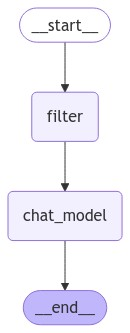

In [7]:
from langchain_core.messages import RemoveMessage
from langchain_core.messages.base import BaseMessage


# Nodes
def filter_messages(state: MessagesState) -> dict[str, list[RemoveMessage]]:
    # Delete all but the 2 most recent messages
    # 最新の2つのメッセージ以外を削除
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}


def chat_model_node(state: MessagesState) -> dict[str, list[BaseMessage]]:
    return {"messages": [llm.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# 前置き付きの message list。前置き = こんにちは。こんにちは。 です。
messages = [AIMessage("こんにちは。", name="Bot", id="1")]
messages.append(HumanMessage("こんにちは。", name="Lance", id="2"))
messages.append(
    AIMessage(
        "海洋哺乳類の研究をしているとおっしゃっていましたよね？",
        name="Bot",
        id="3",
    )
)
messages.append(
    HumanMessage(
        "ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？",
        name="Lance",
        id="4",
    )
)

# Invoke
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

海洋哺乳類の研究をしているとおっしゃっていましたよね？
================================ Human Message =================================
Name: Lance

ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

クジラについて学ぶ際に、以下のポイントも考慮すると良いでしょう：

1. **生態学**: クジラの生息環境、餌の種類、繁殖行動について学ぶと、彼らの生態系における役割が理解できます。

2. **種の多様性**: クジラには多くの種が存在します。それぞれの種の特徴や行動、分布について調べると、全体像が見えてきます。

3. **コミュニケーション**: クジラの音声コミュニケーションや歌についての研究は非常に興味深いです。これにより、彼らの社会的構造や行動についても知識を深められます。

4. **保全**: クジラは多くの脅威にさらされています。環境問題、捕鯨、海洋汚染など、保全に関する知識も重要です。

5. **文化と歴史**: 人間とクジラの関係や、文化的な視点からのクジラの位置づけについて学ぶことも有意義です。

6. **科学技術**: クジラの研究には、衛星追跡や音響技術など、最新の科学技術が利用されています。これらの技術的な側面も興味深いです。

これらの分野を学ぶことで、クジラについての理解がより深まるでしょう。


## Filtering messages

グラフの状態を変更する必要がない場合、または変更したくない場合は、チャットモデルに渡すメッセージをフィルタリングすることができます。

例えば、フィルタリングされたリストを渡すだけです: `llm.invoke(messages[-1:])`をモデルに渡します。


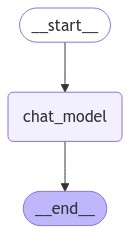

In [11]:
from langchain_core.messages.base import BaseMessage


# Node
def chat_model_node(state: MessagesState) -> dict[str, list[BaseMessage]]:
    # messagesの最後の1つの要素をllmに渡して、その応答を格納する
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

既存のメッセージのリストを受け取り、上記の LLM の応答を追加し、フォローアップの質問を追加してみましょう。


In [12]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("イッカクというクジラについて教えて下さい!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

こんにちは。
================================ Human Message =================================
Name: Lance

こんにちは。
================================== Ai Message ==================================
Name: Bot

海洋哺乳類の研究をしているとおっしゃっていましたよね？
================================ Human Message =================================
Name: Lance

ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

クジラについて学ぶ際に、以下のポイントも考慮すると良いでしょう：

1. **生態学**: クジラの生息環境、餌の種類、繁殖行動について学ぶと、彼らの生態系における役割が理解できます。

2. **種の多様性**: クジラには多くの種が存在します。それぞれの種の特徴や行動、分布について調べると、全体像が見えてきます。

3. **コミュニケーション**: クジラの音声コミュニケーションや歌についての研究は非常に興味深いです。これにより、彼らの社会的構造や行動についても知識を深められます。

4. **保全**: クジラは多くの脅威にさらされています。環境問題、捕鯨、海洋汚染など、保全に関する知識も重要です。

5. **文化と歴史**: 人間とクジラの関係や、文化的な視点からのクジラの位置づけについて学ぶことも有意義です。

6. **科学技術**: クジラの研究には、衛星追跡や音響技術など、最新の科学技術が利用されています。これらの技術的な側面も興味深いです。

これらの分野を学ぶことで、クジラについての理解がより

In [14]:
# メッセージフィルタリングを使って起動
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

こんにちは。
================================ Human Message =================================
Name: Lance

こんにちは。
================================== Ai Message ==================================
Name: Bot

海洋哺乳類の研究をしているとおっしゃっていましたよね？
================================ Human Message =================================
Name: Lance

ええ、クジラについては知っています。でも、他にどんなことを学べばいいですか？
================================== Ai Message ==================================

クジラについて学ぶ際に、以下のポイントも考慮すると良いでしょう：

1. **生態学**: クジラの生息環境、餌の種類、繁殖行動について学ぶと、彼らの生態系における役割が理解できます。

2. **種の多様性**: クジラには多くの種が存在します。それぞれの種の特徴や行動、分布について調べると、全体像が見えてきます。

3. **コミュニケーション**: クジラの音声コミュニケーションや歌についての研究は非常に興味深いです。これにより、彼らの社会的構造や行動についても知識を深められます。

4. **保全**: クジラは多くの脅威にさらされています。環境問題、捕鯨、海洋汚染など、保全に関する知識も重要です。

5. **文化と歴史**: 人間とクジラの関係や、文化的な視点からのクジラの位置づけについて学ぶことも有意義です。

6. **科学技術**: クジラの研究には、衛星追跡や音響技術など、最新の科学技術が利用されています。これらの技術的な側面も興味深いです。

これらの分野を学ぶことで、クジラについての理解がより

ステートにはすべてのメッセージがあります。

しかし、LangSmith のトレースを見て、モデル呼び出しが最後のメッセージしか使っていないことを確認しましょう:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r
(注意:これは原文の英文で Chat したときのリンクです)


## Trim messages

もう一つの方法は、[trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens)で、トークンの数 を指定する方法です。

これはメッセージの履歴を指定されたトークン数に制限します。

フィルタリングはエージェント間のメッセージのポストホックサブセット(post-hoc subset)を返すだけですが、trimming はチャットモデルが応答するために使用できるトークンの数を制限します。

以下の `trim_messages` を参照してください。


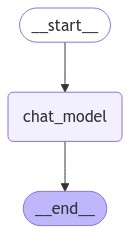

In [15]:
from langchain_core.messages import trim_messages
from langchain_core.messages.base import BaseMessage


# Node
def chat_model_node(state: MessagesState) -> dict[str, list[BaseMessage]]:
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o-mini"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("シャチの居場所を教えて!", name="Lance"))

In [17]:
# Example of trimming messages
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o-mini"),
    allow_partial=False,
)

[HumanMessage(content='シャチの居場所を教えて!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [18]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({"messages": messages})

LangSmith のトレースでモデルの呼び出しを見てみましょう：

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r (注意:これは原文の英文で Chat したときのリンクです)
